In [1]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

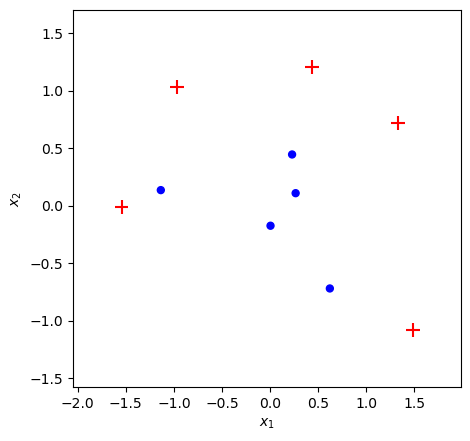

In [3]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

def make_toy_dataset(n: int = 100, random_seed: int = None):
    """ Generate a toy dataset for evaluating AdaBoost classifiers """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_toy_dataset(n=10, random_seed=10)
plot_adaboost(X, y)

Train error: 0.0%


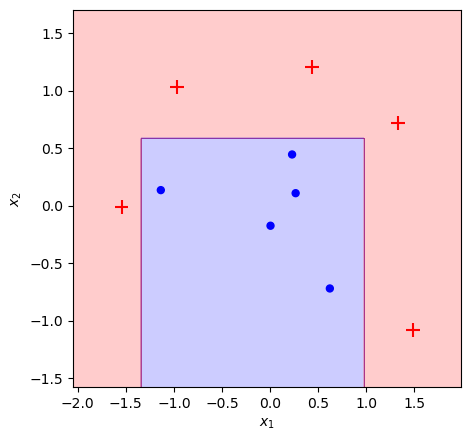

In [4]:
from sklearn.ensemble import AdaBoostClassifier

bench = AdaBoostClassifier(n_estimators=10, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, bench)

train_err = (bench.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

In [5]:
class AdaBoost:
    

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

In [6]:
from sklearn.tree import DecisionTreeClassifier

def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    # init numpy arrays
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    for t in range(iters):
        # fit  weak learner
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()# / n
        stump_weight = np.log((1 - err) / err) / 2

        # update sample weights
        new_sample_weights = (
            curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
        )
        
        new_sample_weights /= new_sample_weights.sum()

        # If not final iteration, update sample weights for t+1
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights

        # save results of iteration
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self
#Making predictions
#We make a final prediction by taking a “weighted majority vote”, calculated as the sign (±) of the linear combination of each stump’s prediction and its corresponding stump weight.

#$$ H_t(x) = \text{sign} \Big( \sum_{t=1}^T a_t h_t(x) \Big) $$

def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))

Train error: 0.0%


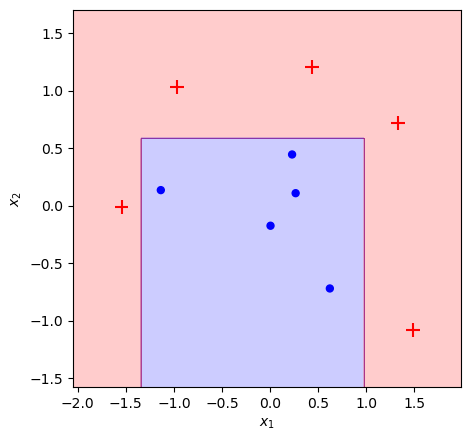

In [7]:
# assign our individually defined functions as methods of our classifier
AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X, y, iters=10)
plot_adaboost(X, y, clf)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

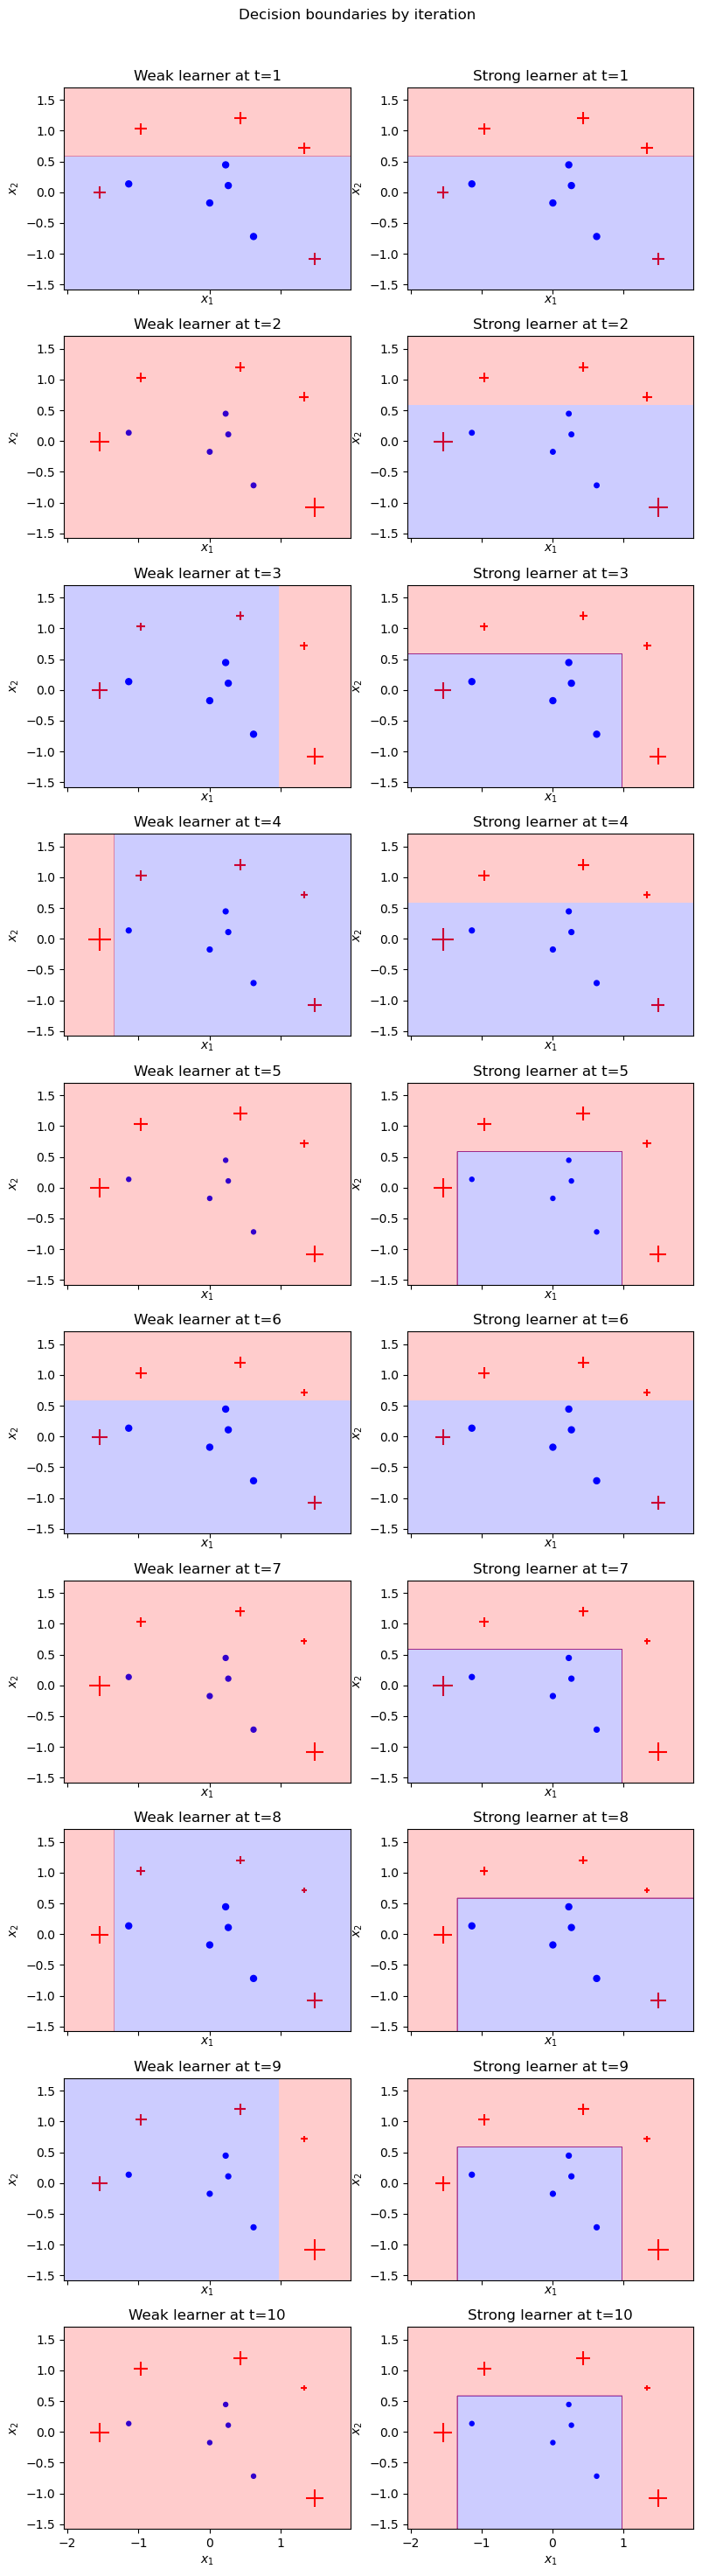

In [8]:
def truncate_adaboost(clf, t: int):
    """ Truncate a fitted AdaBoost up to (and including) a particular iteration """
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=10):
    """ Plot weak learner and cumulaive strong learner at each iteration. """

    # larger grid
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    
    fig.set_facecolor('white')

    _ = fig.suptitle('Decision boundaries by iteration')
    for i in range(iters):
        ax1, ax2 = axes[i]

        # Plot weak learner
        _ = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)

        # Plot strong learner
        trunc_clf = truncate_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

clf = AdaBoost().fit(X, y, iters=10)
plot_staged_adaboost(X, y, clf)